In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Toast Downsell Prediction Model")
print("=" * 50)

Toast Downsell Prediction Model


In [8]:
train_tx = pd.read_csv('train_tx.csv')
train_account = pd.read_csv('train_account.csv')
train_label = pd.read_csv('train_label.csv')
holdout_tx = pd.read_csv('holdout_tx.csv')
holdout_account = pd.read_csv('holdout_account.csv')

print(f"Training transaction data shape: {train_tx.shape}")
print(f"Training account data shape: {train_account.shape}")
print(f"Training labels shape: {train_label.shape}")
print(f"Holdout transaction data shape: {holdout_tx.shape}")
print(f"Holdout account data shape: {holdout_account.shape}")

# Display basic info about datasets
print("\n2. DATA OVERVIEW")
print("-" * 30)

print("\nTraining Transaction Data:")
print(train_tx.head())
print(f"\nData types:\n{train_tx.dtypes}")
print(f"\nMissing values:\n{train_tx.isnull().sum()}")

print("\nTraining Account Data:")
print(train_account.head())
print(f"\nData types:\n{train_account.dtypes}")
print(f"\nMissing values:\n{train_account.isnull().sum()}")

print("\nTraining Labels:")
print(train_label.head())
print(f"\nLabel distribution:\n{train_label['label'].value_counts()}")
print(f"Downsell rate: {train_label['label'].mean():.3f}")


Training transaction data shape: (3510679, 4)
Training account data shape: (10812, 4)
Training labels shape: (10812, 2)
Holdout transaction data shape: (1471016, 4)
Holdout account data shape: (4514, 4)

2. DATA OVERVIEW
------------------------------

Training Transaction Data:
                          Restaurant_ID     Tx_date  processing_volume  \
0  cc3c8fb4-84c6-49c8-bcc7-6d23c626dad5  2021-02-02            3778.49   
1  cc3c8fb4-84c6-49c8-bcc7-6d23c626dad5  2021-02-03            4456.12   
2  cc3c8fb4-84c6-49c8-bcc7-6d23c626dad5  2021-02-04            4868.75   
3  cc3c8fb4-84c6-49c8-bcc7-6d23c626dad5  2021-02-05            5168.63   
4  cc3c8fb4-84c6-49c8-bcc7-6d23c626dad5  2021-02-06            6583.37   

   Tx_hours  
0      12.0  
1      14.0  
2      12.0  
3      14.0  
4      14.0  

Data types:
Restaurant_ID         object
Tx_date               object
processing_volume    float64
Tx_hours             float64
dtype: object

Missing values:
Restaurant_ID        0
Tx_date 


Transaction Data Statistics:
                             Tx_date  processing_volume      Tx_hours
count                        3510679       3.510679e+06  3.510679e+06
mean   2021-08-14 00:12:02.321806080       3.573939e+03  8.851561e+00
min              2021-02-02 00:00:00       0.000000e+00  0.000000e+00
25%              2021-05-18 00:00:00       6.288150e+02  6.000000e+00
50%              2021-08-20 00:00:00       1.942680e+03  1.000000e+01
75%              2021-11-12 00:00:00       4.445410e+03  1.200000e+01
max              2022-02-01 00:00:00       6.077315e+05  2.400000e+01
std                              NaN       5.342567e+03  4.575507e+00

Date range: 2021-02-02 00:00:00 to 2022-02-01 00:00:00
Number of unique restaurants: 10812


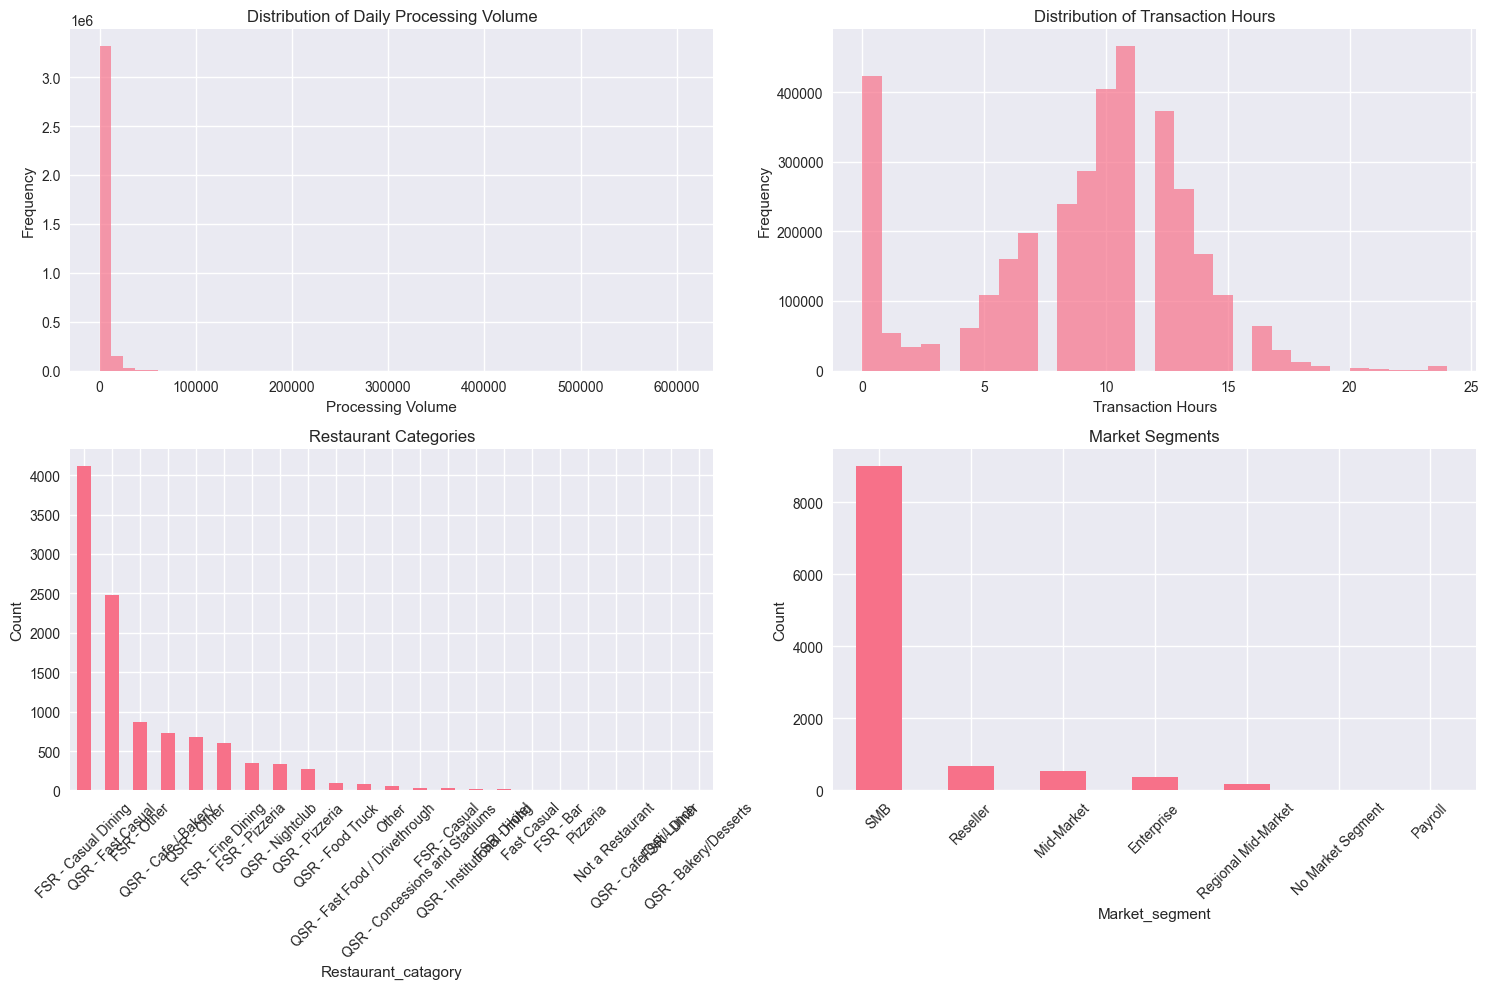

In [14]:
train_tx['Tx_date'] = pd.to_datetime(train_tx['Tx_date'])
holdout_tx['Tx_date'] = pd.to_datetime(holdout_tx['Tx_date'])

# Basic statistics for transaction data
print("\nTransaction Data Statistics:")
print(train_tx.describe())

# Check date range
print(f"\nDate range: {train_tx['Tx_date'].min()} to {train_tx['Tx_date'].max()}")
print(f"Number of unique restaurants: {train_tx['Restaurant_ID'].nunique()}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Daily processing volume distribution
axes[0, 0].hist(train_tx['processing_volume'], bins=50, alpha=0.7)
axes[0, 0].set_title('Distribution of Daily Processing Volume')
axes[0, 0].set_xlabel('Processing Volume')
axes[0, 0].set_ylabel('Frequency')

# 2. Transaction hours distribution
axes[0, 1].hist(train_tx['Tx_hours'], bins=30, alpha=0.7)
axes[0, 1].set_title('Distribution of Transaction Hours')
axes[0, 1].set_xlabel('Transaction Hours')
axes[0, 1].set_ylabel('Frequency')

# 3. Restaurant categories
train_account['Restaurant_catagory'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Restaurant Categories')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Market segments
train_account['Market_segment'].value_counts().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Market Segments')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [18]:
def create_features(tx_data, account_data):
    """
    Create features from transaction and account data
    """
    print("Creating features...")
    
    # Transaction-based features (aggregated per restaurant)
    tx_features = tx_data.groupby('Restaurant_ID').agg({
        'processing_volume': ['mean', 'std', 'min', 'max', 'sum'],
        'Tx_hours': ['mean', 'std', 'min', 'max', 'sum']
    }).reset_index()
    
    # Flatten column names
    tx_features.columns = ['Restaurant_ID'] + [
        f"{col[0]}_{col[1]}" for col in tx_features.columns[1:]
    ]
    
    # Additional transaction features
    tx_daily = tx_data.groupby('Restaurant_ID').agg({
        'Tx_date': ['count', 'nunique'],
        'processing_volume': lambda x: x.quantile(0.75) - x.quantile(0.25)  # IQR
    }).reset_index()
    
    tx_daily.columns = ['Restaurant_ID', 'total_transactions', 'active_days', 'volume_iqr']
    
    # Time-based features
    tx_data['day_of_week'] = tx_data['Tx_date'].dt.dayofweek
    tx_data['month'] = tx_data['Tx_date'].dt.month
    
    # Weekend vs weekday analysis
    tx_data['is_weekend'] = tx_data['day_of_week'].isin([5, 6])
    weekend_features = tx_data.groupby('Restaurant_ID').agg({
        'is_weekend': ['mean', 'sum']
    }).reset_index()
    weekend_features.columns = ['Restaurant_ID', 'weekend_ratio', 'weekend_days']
    
    # Recent trend features (last 30 days)
    tx_data_sorted = tx_data.sort_values(['Restaurant_ID', 'Tx_date'])
    last_30_days = tx_data_sorted.groupby('Restaurant_ID').tail(30)
    
    trend_features = last_30_days.groupby('Restaurant_ID').agg({
        'processing_volume': ['mean', 'std'],
        'Tx_hours': ['mean']
    }).reset_index()
    trend_features.columns = ['Restaurant_ID', 'recent_volume_mean', 'recent_volume_std', 'recent_hours_mean']
    
    # Combine all transaction features
    features = tx_features.merge(tx_daily, on='Restaurant_ID', how='left')
    features = features.merge(weekend_features, on='Restaurant_ID', how='left')
    features = features.merge(trend_features, on='Restaurant_ID', how='left')
    
    # Add account features
    features = features.merge(account_data, on='Restaurant_ID', how='left')
    
    # Fill missing values
    features = features.fillna(0)
    
    return features



In [22]:
train_features = create_features(train_tx, train_account)
holdout_features = create_features(holdout_tx, holdout_account)

print(f"Training features shape: {train_features.shape}")
print(f"Holdout features shape: {holdout_features.shape}")

# Merge with labels for training
train_data = train_features.merge(train_label, on='Restaurant_ID', how='left')
print(f"Final training data shape: {train_data.shape}")


Creating features...
Creating features...
Training features shape: (10812, 22)
Holdout features shape: (4514, 22)
Final training data shape: (10812, 23)


In [38]:
# Quick fix: Redefine the function with the encoders parameter
def preprocess_data(data, is_training=True, encoders=None):
    """
    Preprocess the data for modeling
    """
    data_processed = data.copy()
    
    # Encode categorical variables
    categorical_cols = ['Ownership_type', 'Restaurant_catagory', 'Market_segment']
    label_encoders = {}
    
    for col in categorical_cols:
        if col in data_processed.columns:
            if is_training:
                le = LabelEncoder()
                data_processed[col] = le.fit_transform(data_processed[col].astype(str))
                label_encoders[col] = le
            else:
                # For holdout data, use the same encoder as training
                if encoders and col in encoders:
                    le = encoders[col]
                    # Handle unseen categories by mapping them to a default value
                    unique_values = set(data_processed[col].astype(str).unique())
                    known_values = set(le.classes_)
                    unseen_values = unique_values - known_values
                    
                    if unseen_values:
                        print(f"Warning: Unseen categories in {col}: {unseen_values}")
                        # Map unseen categories to the most frequent category
                        most_frequent = le.classes_[0]
                        data_processed[col] = data_processed[col].astype(str).replace(
                            list(unseen_values), most_frequent
                        )
                    
                    data_processed[col] = le.transform(data_processed[col].astype(str))
                    label_encoders[col] = le
                else:
                    # If no encoder provided, create a new one (fallback)
                    le = LabelEncoder()
                    data_processed[col] = le.fit_transform(data_processed[col].astype(str))
                    label_encoders[col] = le
    
    return data_processed, label_encoders

# Now preprocess holdout data with the encoders
holdout_processed, _ = preprocess_data(holdout_features, is_training=False, encoders=encoders)


6. MODEL APPROACH 1: RANDOM FOREST
------------------------------
Training set size: 8649
Validation set size: 2163
Random Forest AUC: 0.7629

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      1958
         1.0       0.31      0.44      0.36       205

    accuracy                           0.85      2163
   macro avg       0.62      0.67      0.64      2163
weighted avg       0.88      0.85      0.86      2163


Top 10 Most Important Features:
                   feature  importance
15      recent_volume_mean    0.176971
17       recent_hours_mean    0.116512
0   processing_volume_mean    0.111918
4    processing_volume_sum    0.086010
5            Tx_hours_mean    0.069004
16       recent_volume_std    0.063933
6             Tx_hours_std    0.054511
3    processing_volume_max    0.053865
12              volume_iqr    0.050703
9             Tx_hours_sum    0.049791


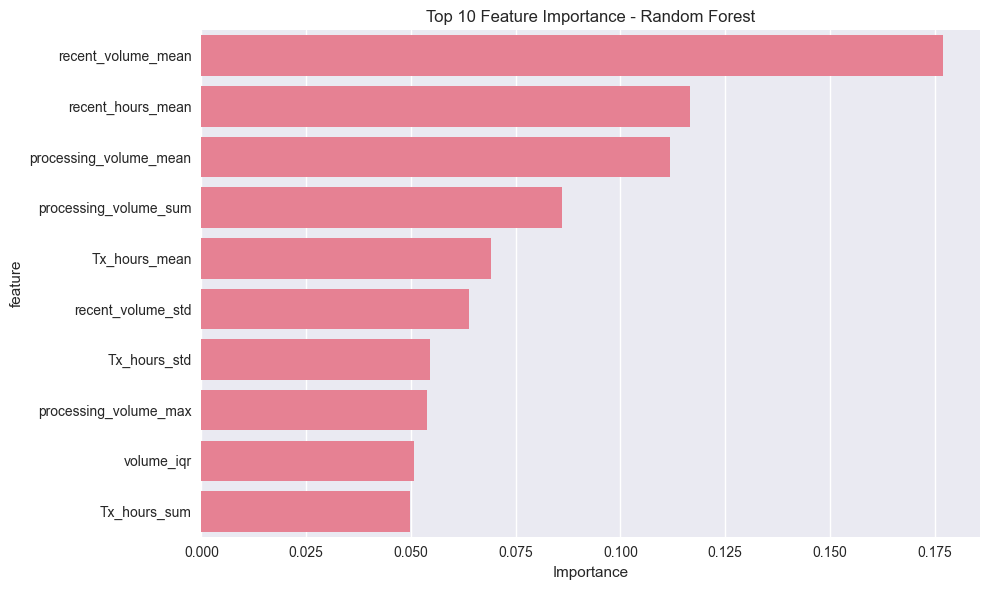

In [40]:
print("\n6. MODEL APPROACH 1: RANDOM FOREST")
print("-" * 30)

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_val)
rf_pred_proba = rf_model.predict_proba(X_val)[:, 1]

# Evaluate the model
rf_auc = roc_auc_score(y_val, rf_pred_proba)
print(f"Random Forest AUC: {rf_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, rf_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


Cross-validation AUC scores: [0.79069359 0.77133212 0.73585752 0.75746601 0.77579172]
Mean CV AUC: 0.7662 (+/- 0.0370)
Gradient Boosting AUC: 0.7479

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      1958
         1.0       0.55      0.16      0.25       205

    accuracy                           0.91      2163
   macro avg       0.73      0.57      0.60      2163
weighted avg       0.88      0.91      0.88      2163


8. MODEL COMPARISON
------------------------------
Random Forest AUC: 0.7629
Gradient Boosting AUC: 0.7479


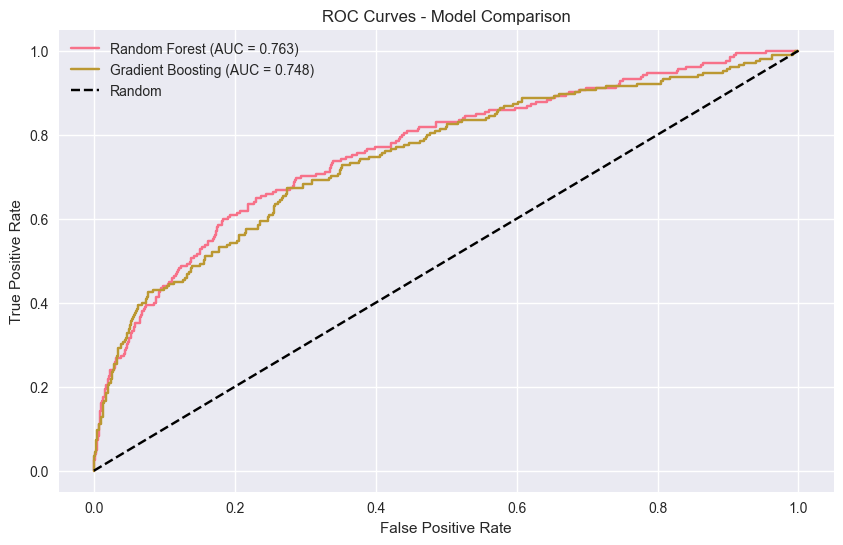

In [41]:

# Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Cross-validation
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='roc_auc')
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train on full training set
gb_model.fit(X_train, y_train)

# Make predictions
gb_pred = gb_model.predict(X_val)
gb_pred_proba = gb_model.predict_proba(X_val)[:, 1]

# Evaluate the model
gb_auc = roc_auc_score(y_val, gb_pred_proba)
print(f"Gradient Boosting AUC: {gb_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, gb_pred))

# Compare models
print("\n8. MODEL COMPARISON")
print("-" * 30)
print(f"Random Forest AUC: {rf_auc:.4f}")
print(f"Gradient Boosting AUC: {gb_auc:.4f}")

# ROC Curves
plt.figure(figsize=(10, 6))

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_pred_proba)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})')

# Gradient Boosting ROC
fpr_gb, tpr_gb, _ = roc_curve(y_val, gb_pred_proba)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
if rf_auc > gb_auc:
    final_model = rf_model
    model_name = "Random Forest"
    print(f"Selected model: {model_name} (AUC: {rf_auc:.4f})")
else:
    final_model = gb_model
    model_name = "Gradient Boosting"
    print(f"Selected model: {model_name} (AUC: {gb_auc:.4f})")

# Retrain on full dataset for final predictions
final_model.fit(X, y)

# Preprocess holdout data
holdout_processed, _ = preprocess_data(holdout_features, is_training=False, encoders=encoders)

# Ensure holdout data has the same features as training
holdout_X = holdout_processed[feature_cols]

# Make predictions on holdout data
holdout_predictions = final_model.predict_proba(holdout_X)[:, 1]

# Create submission file
submission = pd.DataFrame({
    'Restaurant_ID': holdout_features['Restaurant_ID'],
    'pred': holdout_predictions
})

print(f"Holdout predictions shape: {submission.shape}")
print(f"Prediction statistics:")
print(submission['pred'].describe())

# Save predictions
submission.to_csv('toast_downsell_predictions.csv', index=False)
print("\nPredictions saved to 'toast_downsell_predictions.csv'")

Selected model: Random Forest (AUC: 0.7629)
Holdout predictions shape: (4514, 2)
Prediction statistics:
count    4514.000000
mean        0.240591
std         0.170963
min         0.013990
25%         0.112929
50%         0.193974
75%         0.321418
max         0.974562
Name: pred, dtype: float64

Predictions saved to 'toast_downsell_predictions.csv'


Key Business Insights:
1. Most important features for predicting downsell:
   - recent_volume_mean: 0.1770
   - recent_hours_mean: 0.1165
   - processing_volume_mean: 0.1119
   - processing_volume_sum: 0.0860
   - Tx_hours_mean: 0.0690

2. Customer segments analysis:
   Market_segment  count      mean
0               0    383  0.031332
1               1    540  0.055556
2               2     11  0.181818
3               3      2  0.000000
4               4    175  0.062857
5               5    686  0.080175
6               6   9015  0.101498

3. Restaurant category analysis:
    Restaurant_catagory  count      mean
0                     0      3  0.000000
1                     1      8  0.125000
2                     2     27  0.037037
3                     3   4121  0.082262
4                     4      2  0.000000
5                     5    605  0.080992
6                     6     15  0.200000
7                     7    872  0.086009
8                     8    345  0.078261
9       

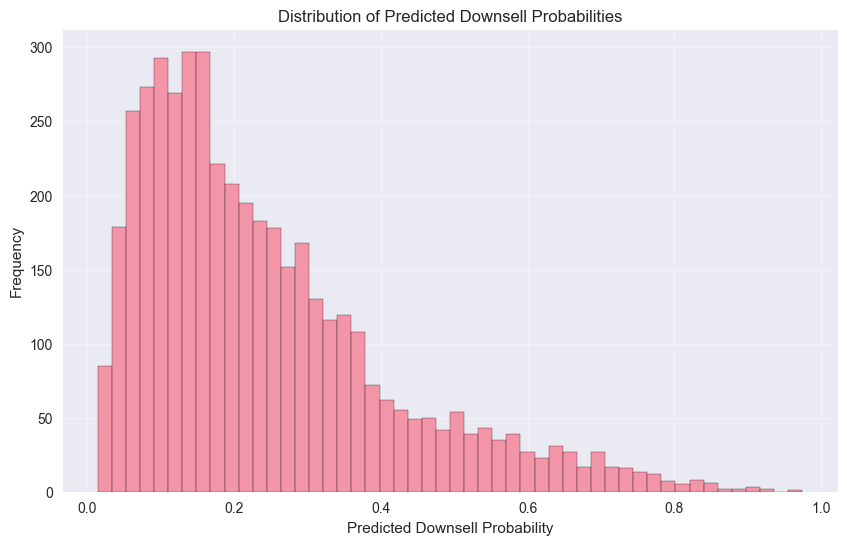


High-risk customers (probability > 0.5): 439
Medium-risk customers (0.2 < probability < 0.5): 1751
Low-risk customers (probability < 0.2): 2324


In [49]:
print("Key Business Insights:")
print("1. Most important features for predicting downsell:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print("\n2. Customer segments analysis:")
segment_analysis = train_processed.groupby('Market_segment')['label'].agg(['count', 'mean']).reset_index()
print(segment_analysis)

print("\n3. Restaurant category analysis:")
category_analysis = train_processed.groupby('Restaurant_catagory')['label'].agg(['count', 'mean']).reset_index()
print(category_analysis)

# Prediction distribution
plt.figure(figsize=(10, 6))
plt.hist(holdout_predictions, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Downsell Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Downsell Probabilities')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nHigh-risk customers (probability > 0.5): {(holdout_predictions > 0.5).sum()}")
print(f"Medium-risk customers (0.2 < probability < 0.5): {((holdout_predictions > 0.2) & (holdout_predictions <= 0.5)).sum()}")
print(f"Low-risk customers (probability < 0.2): {(holdout_predictions <= 0.2).sum()}")

In [51]:

print("\n11. FURTHER IMPROVEMENTS AND NEXT STEPS")
print("-" * 30)

improvements = [
    "1. Time series analysis: Model temporal patterns and seasonality",
    "2. Advanced feature engineering: Create interaction features, ratio features",
    "3. External data: Incorporate economic indicators, local market data",
    "4. Ensemble methods: Combine multiple models for better predictions",
    "5. Deep learning: Try neural networks for complex pattern recognition",
    "6. Customer segmentation: Build separate models for different segments",
    "7. Real-time monitoring: Implement model drift detection and retraining",
    "8. Causal inference: Understand the drivers of downsell beyond correlation"
]

for improvement in improvements:
    print(improvement)

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"Final model: {model_name}")
print(f"Model performance: {max(rf_auc, gb_auc):.4f} AUC")
print(f"Predictions saved to: toast_downsell_predictions.csv")
print("="*60)


11. FURTHER IMPROVEMENTS AND NEXT STEPS
------------------------------
1. Time series analysis: Model temporal patterns and seasonality
2. Advanced feature engineering: Create interaction features, ratio features
3. External data: Incorporate economic indicators, local market data
4. Ensemble methods: Combine multiple models for better predictions
5. Deep learning: Try neural networks for complex pattern recognition
6. Customer segmentation: Build separate models for different segments
7. Real-time monitoring: Implement model drift detection and retraining
8. Causal inference: Understand the drivers of downsell beyond correlation

ANALYSIS COMPLETE
Final model: Random Forest
Model performance: 0.7629 AUC
Predictions saved to: toast_downsell_predictions.csv
